# 1. Imports and config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import time

pd.set_option('display.width', 120)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

START = '2020-01-01'
END = None

COMMODITY_TICKERS = {
    'Brent':   'BZ=F',
    'Nat Gas': 'NG=F',
    'Gold':    'GC=F',
    'Copper':  'HG=F',
    'Corn':    'ZC=F',
    'Wheat':   'ZW=F',
}

MACRO_TICKERS = {
    'S&P500': '^GSPC',
    '10Y_Treasury_Yield': '^TNX',
    'USD_Index': 'DX-Y.NYB'
}

ROLLING_WINDOW = 60
LAG_DAYS = 5

# 2. Fetching data

In [2]:
tickers = list(COMMODITY_TICKERS.values()) + list(MACRO_TICKERS.values())

raw = yf.download(
    tickers,
    start=START, end=END,
    auto_adjust=True, progress=False
)

if isinstance(raw.columns, pd.MultiIndex):
    prices = raw['Close'].copy()
else:
    prices = raw[['Close']].copy()

label_map = {v: k for k, v in (COMMODITY_TICKERS | MACRO_TICKERS).items()}
prices = prices.rename(columns=label_map).sort_index()

prices = prices.dropna(axis=1, how="all").ffill().dropna()
prices.tail()


Ticker,Brent,USD_Index,Gold,Copper,Nat Gas,Corn,Wheat,S&P500,10Y_Treasury_Yield
Date,,,,,,,,,
2025-09-08,66.0200,97.4500,"3,638.1001",4.4905,3.0900,403.0000,505.5000,"6,495.1499",4.0460
2025-09-09,66.3900,97.7900,"3,643.3000",4.5010,3.1170,401.2500,500.7500,"6,512.6099",4.0740
2025-09-10,67.4900,97.7800,"3,643.6001",4.5500,3.0290,397.2500,495.0000,"6,532.0400",4.0320
2025-09-11,66.3700,97.5400,"3,636.8999",4.5905,2.9340,399.0000,503.0000,"6,587.4702",4.0110
2025-09-12,66.9900,97.5500,"3,649.3999",4.5885,2.9410,399.0000,503.0000,"6,584.2900",4.0610


# 3. Converting prices to returns and static correlation matrix

Ticker               Brent  USD_Index    Gold  Copper  Nat Gas    Corn   Wheat  S&P500  10Y_Treasury_Yield
Ticker                                                                                                    
Brent               1.0000    -0.0319  0.1383  0.2757   0.0834  0.1717  0.1411  0.2596              0.2339
USD_Index          -0.0319     1.0000 -0.4037 -0.3342  -0.0145 -0.0276 -0.0248 -0.1657              0.2181
Gold                0.1383    -0.4037  1.0000  0.2910   0.0302  0.0880  0.1051  0.1029             -0.2123
Copper              0.2757    -0.3342  0.2910  1.0000   0.0357  0.1200  0.1009  0.2349              0.0617
Nat Gas             0.0834    -0.0145  0.0302  0.0357   1.0000  0.0562  0.0519  0.0991              0.0278
Corn                0.1717    -0.0276  0.0880  0.1200   0.0562  1.0000  0.4683  0.0348              0.0472
Wheat               0.1411    -0.0248  0.1051  0.1009   0.0519  0.4683  1.0000  0.0199              0.0145
S&P500              0.2596    -0.1657

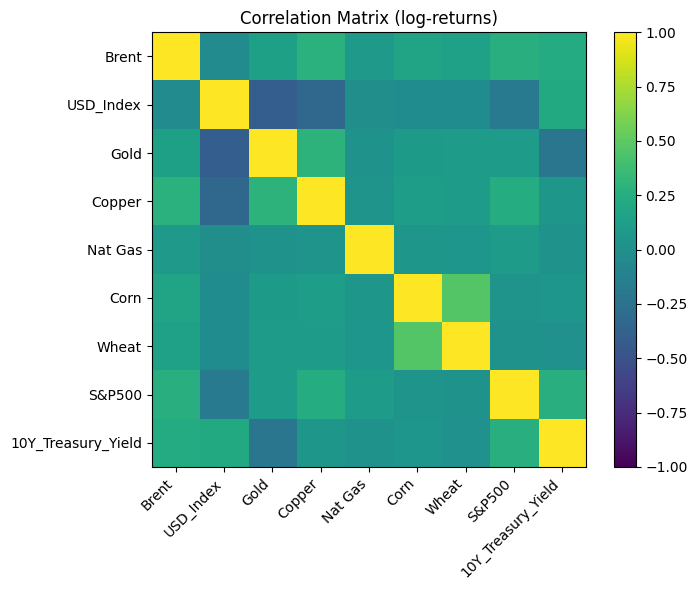

In [3]:
returns = np.log(prices).diff().dropna()
returns.describe()

corr = returns.corr(method='pearson')
print(corr)

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(range(len(corr.index)));   ax.set_yticklabels(corr.index)
ax.set_title("Correlation Matrix (log-returns)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 4. Rolling Correlations

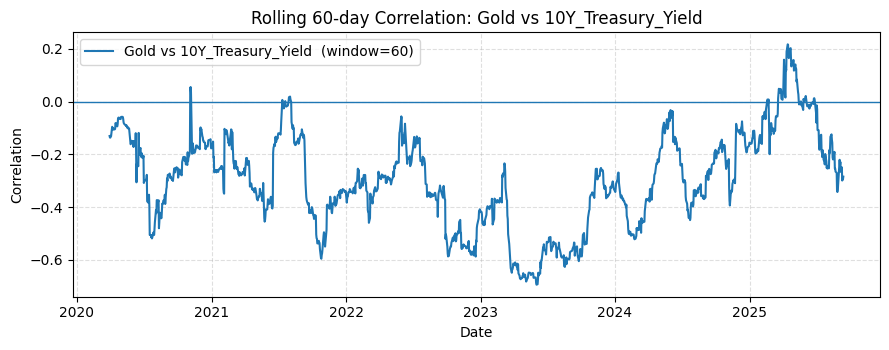

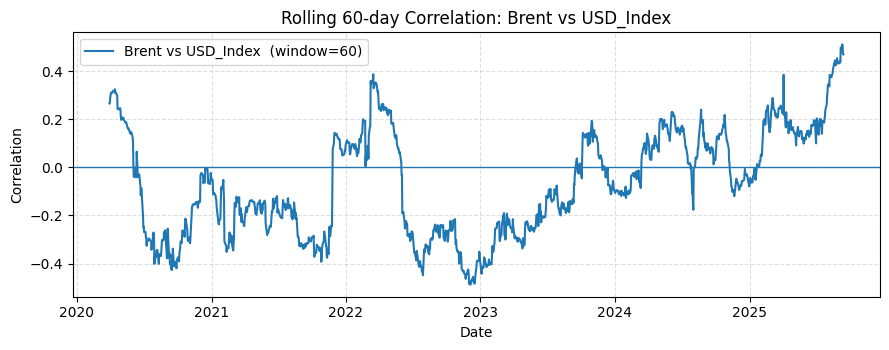

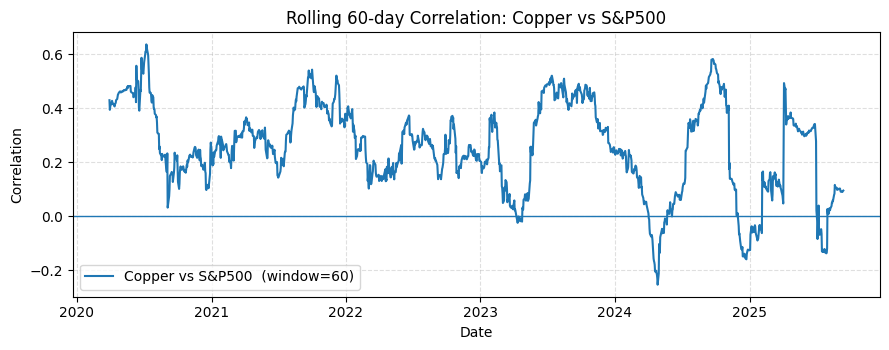

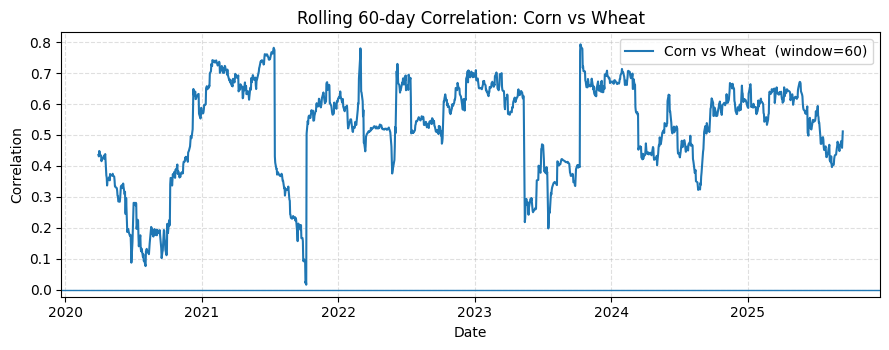

Rolling correlation stats (window = 60 )


,mean,min,max
pair,,,
Gold-10Y_Treasury_Yield,-0.2980,-0.6937,0.2175
Brent-USD_Index,-0.0686,-0.4878,0.5116
Copper-S&P500,0.2564,-0.2532,0.6373
Corn-Wheat,0.5214,0.0161,0.7929


In [4]:
pairs = [
    ('Gold',  '10Y_Treasury_Yield'),  
    ('Brent', 'USD_Index'),           
    ('Copper','S&P500'),              
    ('Corn',  'Wheat'),               
]

def plot_rolling_corr(returns_df, pair_list, window=60, save=False, save_prefix='rolling_corr_'):
    summary = []
    for a, b in pair_list:
        if a not in returns_df.columns or b not in returns_df.columns:
            print(f'Skipping ({a}, {b}) — missing in returns columns.')
            continue

        roll = returns_df[a].rolling(window).corr(returns_df[b])

        stats = {
            'pair': f'{a}-{b}',
            'mean': float(roll.mean()),
            'min':  float(roll.min()),
            'max':  float(roll.max())
        }
        summary.append(stats)

        fig, ax = plt.subplots(figsize=(9, 3.6))
        ax.plot(roll.index, roll.values, label=f'{a} vs {b}  (window={window})')
        ax.axhline(0, linewidth=1)
        ax.set_title(f'Rolling {window}-day Correlation: {a} vs {b}')
        ax.set_xlabel('Date'); ax.set_ylabel('Correlation')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend()
        plt.tight_layout()

        if save:
            fname = f'{save_prefix}{a.replace(" ","_")}_vs_{b.replace(" ","_")}.png'
            plt.savefig(fname, dpi=150, bbox_inches='tight')
        plt.show()

    if summary:
        print('Rolling correlation stats (window =', window, ')')
        display(pd.DataFrame(summary).set_index('pair'))


plot_rolling_corr(returns, pairs, window=ROLLING_WINDOW, save=False)


# 5. Lead/lag check


Pair: Gold vs 10Y_Treasury_Yield
-10   -0.0372
-9     0.0351
-8    -0.0146
-7     0.0584
-6    -0.0814
-5     0.0475
-4     0.0800
-3     0.0285
-2     0.0041
-1    -0.1076
 0    -0.2123
 1     0.0448
 2    -0.0106
 3    -0.0378
 4    -0.0756
 5     0.0640
 6     0.0715
 7    -0.0306
 8    -0.0282
 9    -0.0024
 10   -0.0254
dtype: float64
Max |corr| at lag 0 days -> corr = -0.2123


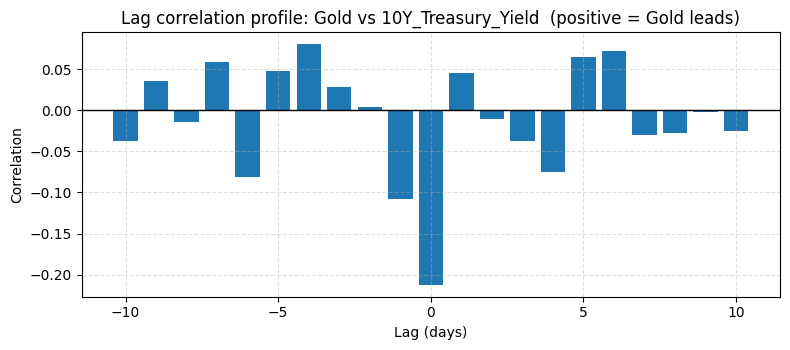


Pair: Brent vs USD_Index
-10    0.0408
-9     0.0365
-8    -0.0283
-7    -0.0084
-6     0.0052
-5     0.0105
-4    -0.0509
-3    -0.0407
-2     0.0491
-1     0.0415
 0    -0.0319
 1    -0.0549
 2     0.0018
 3    -0.0168
 4    -0.0327
 5     0.0246
 6    -0.0114
 7     0.0124
 8     0.0051
 9    -0.0110
 10    0.0017
dtype: float64
Max |corr| at lag 1 days -> corr = -0.0549


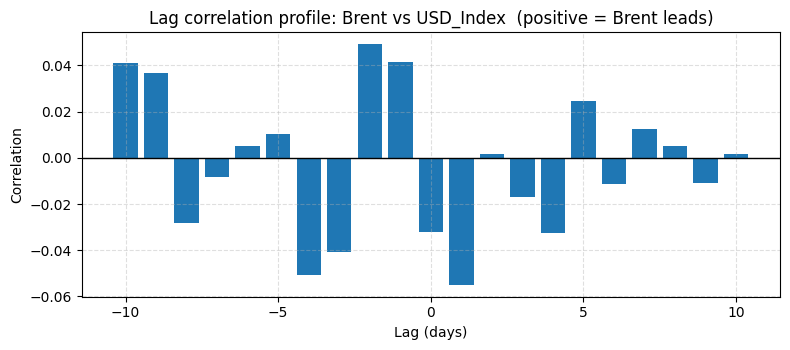


Pair: Copper vs S&P500
-10    0.0150
-9    -0.0107
-8     0.0123
-7     0.0651
-6    -0.0450
-5     0.0247
-4     0.0107
-3    -0.0184
-2     0.0483
-1     0.0809
 0     0.2349
 1    -0.0198
 2     0.0324
 3    -0.0117
 4     0.0161
 5    -0.0361
 6    -0.0506
 7    -0.0101
 8    -0.0317
 9     0.0127
 10    0.0203
dtype: float64
Max |corr| at lag 0 days -> corr = 0.2349


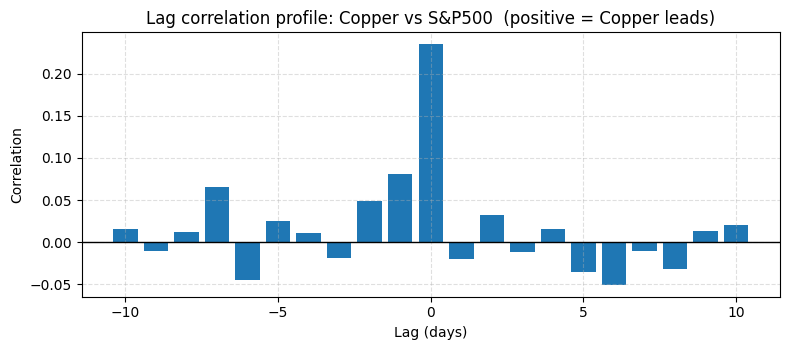


Pair: Corn vs Wheat
-10   -0.0152
-9     0.0226
-8     0.0303
-7    -0.0301
-6     0.0294
-5    -0.0596
-4    -0.0379
-3     0.0541
-2    -0.0004
-1    -0.0203
 0     0.4683
 1     0.0024
 2     0.0075
 3     0.0164
 4    -0.0353
 5    -0.0130
 6     0.0116
 7     0.0295
 8     0.0040
 9    -0.0234
 10    0.0130
dtype: float64
Max |corr| at lag 0 days -> corr = 0.4683


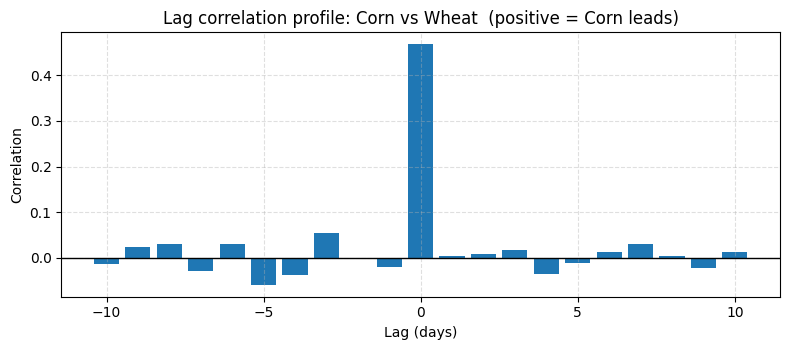

In [5]:
def lag_sweep_corr(series_lead, series_lag, max_lag=10):
    '''
    Compute correlations at different lags.
    Positive k = series_lead shifted forward (i.e. leads by k days).
    Negative k = series_lead lags.
    '''
    out = {}
    for k in range(-max_lag, max_lag + 1):
        c = series_lead.shift(k).corr(series_lag)
        out[k] = c
    return pd.Series(out).sort_index()

pairs = [
    ('Gold',  '10Y_Treasury_Yield'),
    ('Brent', 'USD_Index'),
    ('Copper','S&P500'),
    ('Corn',  'Wheat'),
]

for a, b in pairs:
    if a not in returns.columns or b not in returns.columns:
        print(f'Skipping ({a}, {b}) — missing in returns data.')
        continue

    lag_corrs = lag_sweep_corr(returns[a], returns[b], max_lag=10)

    best_k = lag_corrs.abs().idxmax()
    print(f'\nPair: {a} vs {b}')
    print(lag_corrs)
    print(f'Max |corr| at lag {best_k} days -> corr = {lag_corrs.loc[best_k]:.4f}')

    fig, ax = plt.subplots(figsize=(8, 3.6))
    ax.bar(lag_corrs.index, lag_corrs.values, width=0.8)
    ax.axhline(0, color='black', lw=1)
    ax.set_title(f'Lag correlation profile: {a} vs {b}  (positive = {a} leads)')
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Correlation')
    ax.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
